In [1]:
import pandas as pd
import numpy as np

from sklearn import ensemble

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesOrdinalManualFeatures.csv', index_col=0)
AmesDummiesOrdinal.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,Exterior_Stone,Exterior_ImStucc,Exterior_Other,ProximityBonus,YearsAgoBuilt,YearsSinceRemodel,YearsSinceSale,MoSold_Autumn,MoSold_Spring,MoSold_Winter
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,0,4,1,7,5,196.0,4,3,...,0,0,0,0,8,8,3,0,0,1
2,80.0,9600,0,4,1,6,8,0.0,3,3,...,0,0,0,0,35,35,4,0,1,0
3,68.0,11250,1,4,1,7,5,162.0,4,3,...,0,0,0,0,10,9,3,1,0,0
4,60.0,9550,1,4,1,7,5,0.0,3,3,...,0,0,0,0,96,41,5,0,0,1
5,84.0,14260,1,4,1,8,5,350.0,4,3,...,0,0,0,0,11,11,3,0,0,1


In [2]:
# #Load the RF and XGB features, which contains the list of Features to include in the linear model:
# rfFeatures = pd.read_csv('rfFeatures.csv')
# xgbFeatures = pd.read_csv('xgbFeatures.csv')

# #Change column head
# lst = [rfFeatures, xgbFeatures]
# for df in lst:
#     df.columns = ['Feature','Score']

In [3]:
manualFeat = pd.read_csv('AmesOrdinalManualAICFinal.csv', index_col=0)
manualFeatures = list(manualFeat.columns)
manualFeatures

['Neighborhood_BrDale',
 'GarageType_Detchd',
 'Neighborhood_NPkVill',
 'SalePrice',
 'MasVnrType_BrkFace',
 'Neighborhood_NridgHt',
 'PoolQC',
 'Neighborhood_NWAmes',
 'SaleCondition_Abnorml',
 'OverallQual',
 'GarageType_No',
 'Neighborhood_Blmngtn',
 'Fence_GdPrv',
 'TotRmsAbvGrd',
 'Neighborhood_Sawyer',
 'Functional',
 'TotalSF',
 'ScreenPorch',
 'Foundation_Slab',
 'YearsAgoBuilt',
 'BsmtQual',
 'LotArea',
 'MasVnrArea',
 'BldgType_Twnhs',
 'BldgType_Duplex',
 'Condition_Artery',
 'GarageScore',
 'BldgType_TwnhsE',
 'OverallCond',
 'GarageArea',
 'BsmtExposure',
 'Neighborhood_Crawfor',
 'MoSold_Spring',
 'GarageType_BuiltIn',
 'MSZoning_FV',
 'TotalBath',
 'Neighborhood_BrkSide',
 'Street_Grvl',
 'RoofMatl_WdShngl',
 'Exterior_Stucco',
 'HouseStyle_2Story',
 'Exterior_MetalSd',
 'Condition_Feedr',
 'SaleType_New',
 'ExterCond',
 'RoofStyle_Hip',
 'Exterior_CemntBd',
 'LotConfig_CulDSac',
 'Neighborhood_StoneBr',
 'TotalBsmtSF',
 'HouseStyle_1.5Fin',
 'BedroomAbvGr',
 'MasVnrType

In [11]:
amesDF = AmesDummiesOrdinal[manualFeatures]

In [12]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

amesDF2 = amesDF.copy()
amesDF = amesDF.iloc[trainIdxes,]
amesDFTest = amesDF2.iloc[testIdxes,]

In [13]:
amesDF.shape
amesDFTest.shape

(292, 62)

In [14]:
amesDF.shape

(1166, 62)

In [17]:
#Reset indices of AmesDF
amesDF.index = range(1166)

In [18]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [19]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [50, 100, 200, 400, 600, 800, 1000, 1200]
# Type of loss
loss = ['ls', 'lad', 'huber']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 10, 15]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
max_features = ['auto', 'sqrt', 'log2', None]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'loss': loss}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gradientBoost = ensemble.GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gradientBoost_random = RandomizedSearchCV(estimator = gradientBoost, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
gradientBoost_random.fit(amesDF.drop('SalePrice', axis=1), amesDF['SalePrice'])

#Then print the best parameters using best_params_
gradientBoost_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   4.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   4.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   4.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   4.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   4.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=15, loss=huber 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=None, max_dep

[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   1.0s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   1.0s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   1.0s
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls, total=   0.8s
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3

[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad, total=   0.4s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad, total=   0.5s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber, total=   5.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber, total=   5.7s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, m

[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features=log2, max_depth=2, loss=huber, total=   1.5s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   1.2s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   1.2s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   1.2s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   7.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   7.2s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   7.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   7.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto,

[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   0.3s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   0.3s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   0.3s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   0.3s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, los

[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   1.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   1.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   1.5s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls, total=   0.1s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad, total=  12.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad, total=  13.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad, total=   1.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad, total=   1.5s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=aut

[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=2, loss=huber, total=   0.7s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  20.3s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  20.3s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  20.5s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto,

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_dept

[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max

[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   1.1s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   1.1s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   1.1s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber, total=  32.5s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt,

[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls, total=   8.0s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls, total=   6.1s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad, total=   1.5s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad, total=   1.5s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_d

[CV]  n_estimators=1200, min_samples_split=4, min_samples_leaf=8, max_features=sqrt, max_depth=15, loss=huber, total=  16.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   0.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   0.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   0.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 41.0min finished


{'n_estimators': 1000,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 3,
 'loss': 'huber'}

In [20]:
#The grid search optimization revealed optimal parameters. Let's set these to the gradientBoost function:
gradientBoost2 = ensemble.GradientBoostingRegressor()
gradientBoost2.set_params(n_estimators=1000, min_samples_split=6, min_samples_leaf=1, max_features='sqrt', max_depth=3, loss='huber')

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [21]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = amesDF.drop('SalePrice', axis=1)
Y = amesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = amesDFTest.drop('SalePrice', axis=1)
testY = amesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(amesDF.drop('SalePrice', axis=1), amesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    gradientBoost2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = gradientBoost2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = gradientBoost2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = gradientBoost2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = gradientBoost2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [10]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.9075668721076866, 0.9324486950628464, 0.9476875471483919, 0.9061340601242542, 0.9073135462657624]
[0.9153642750097969, 0.9253707748201562, 0.9192320310619537, 0.9255753846146455, 0.9205837406767228]
[0.12284928302678036, 0.11297767438573281, 0.11339476347907987, 0.11016808916089789, 0.11916114082798697]


In [24]:
'''Of the three tests performed thus far (Linear, Random Forest, and now Gradient Boost), the gradient boost results are 
clearly the best, with a RMSLE of approximately 0.117173193'''

'Of the three tests performed thus far (Linear, Random Forest, and now Gradient Boost), the gradient boost results are \nclearly the best, with a RMSLE of approximately 0.117173193'

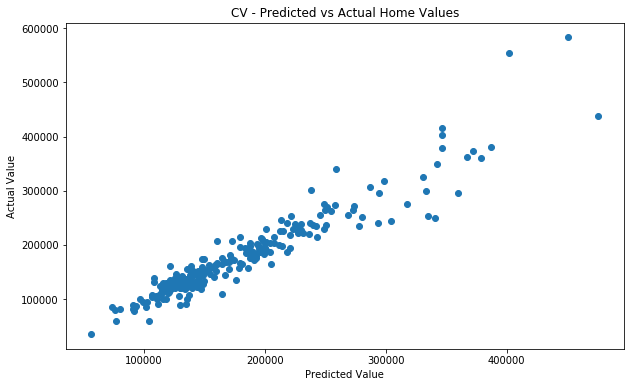

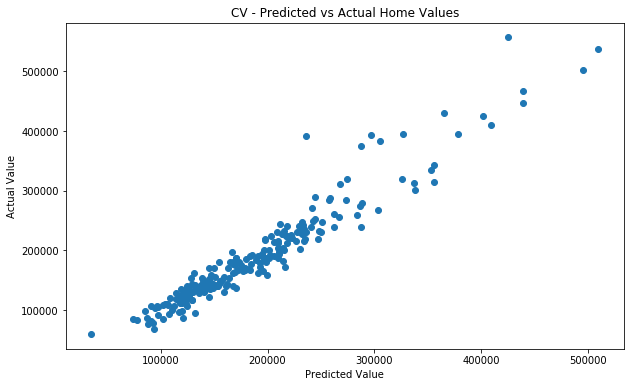

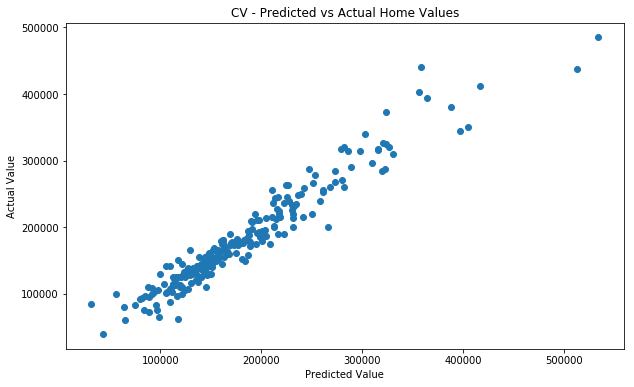

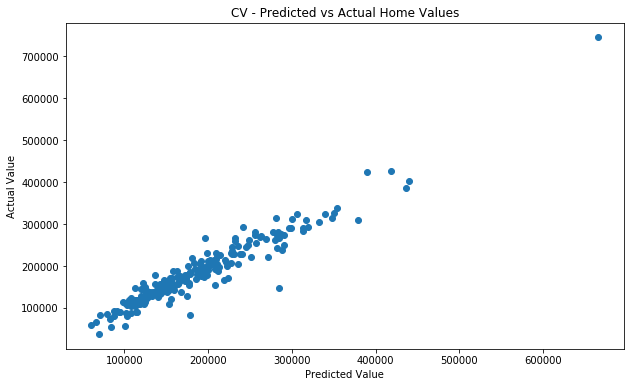

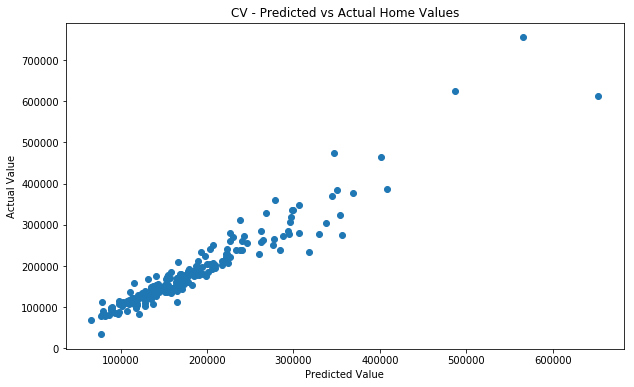

In [26]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [27]:
from xgboost import XGBRegressor

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [600, 800, 1000, 1200, 2000]
# Type of loss
loss = ['ls', 'lad', 'huber']
# Maximum number of levels in tree
max_depth = [2, 3, 4, 5]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
max_features = ['auto', 'sqrt', 'log2', None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_child_weight': [1, 5],
               'colsample_bytree': [0.6],
               'gamma': [0.1, 0.2],
               'loss': loss}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
xgb_random.fit(amesDF.drop('SalePrice', axis=1), amesDF['SalePrice'])

#Then print the best parameters using best_params_
xgb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.2s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   1.5s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6 
[

[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   3.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=6, min_child_weight=5, max_features=auto, max_depth=4, loss=ls, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=6, min_child_weight=5, max_features=auto, max_depth=4, loss=ls, gamma=0.2, colsample_bytree=0.6, total=   3.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=6, min_child_weight=5, max_features=auto, max_depth=4, loss=ls, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=6, min_child_weight=5, max_features=auto, max_depth=4, loss=ls, gamma=0.2, colsample_bytree=0.6, total=   3.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=6, min_child_weight=5, max_features=auto, max_depth=4, loss=ls, gamma=0.2, colsample_bytree=0.6 


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   1.3s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   1.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   1.3s
[CV] n_estimators=1200, min_samples_split=4, min_samples_leaf=6, min_child_weight=5, max_features=None, max_depth=3, loss=huber, gamma=0.2, colsample_

[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, min_child_weight=5, max_features=None, max_depth=5, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   4.2s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, min_child_weight=5, max_features=None, max_depth=5, loss=huber, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, min_child_weight=5, max_features=None, max_depth=5, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   4.1s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=1, min_child_weight=1, max_features=None, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=1, min_child_weight=1, max_features=None, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=1, min_child_weight=1, max_features=None, max_depth=5, loss=ls, gamma=0.1, colsample_bytr

[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, min_child_weight=1, max_features=auto, max_depth=5, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   4.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_child_weight=5, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_child_weight=5, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   3.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_child_weight=5, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_child_weight=5, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   3.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_child_weight=5, max_features=auto, max_depth=4, loss=lad, gamma=0.2, colsample_bytr

[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   3.4s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   3.5s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   3.5s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=8, min_child_weight=5, max_features=log2, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, min_child_weight=5, max_features=None, max_depth=2, loss=lad, gamma=0.1, colsample_bytree=0.6, total=   2.3s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=4, min_child_weight=5, max_features=None, max_depth=2, loss=lad, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, min_child_weight=5, max_features=None, max_depth=2, loss=lad, gamma=0.1, colsample_bytree=0.6, total=   2.5s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=sqrt, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=sqrt, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   1.9s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, min_child_weight=1, max_features=sqrt, max_depth=3, loss=ls, gamma=0.1, colsample_bytree=0.6 
[

[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   2.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.1, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.1, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.1, colsample_bytre

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=3, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   2.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=3, loss=huber, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=3, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   2.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=3, loss=huber, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=3, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   2.5s
[CV] n_estimators=1200, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=log2, max_depth=5, loss=huber, gamma=0.1, colsa

[CV]  n_estimators=1200, min_samples_split=4, min_samples_leaf=4, min_child_weight=1, max_features=log2, max_depth=2, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   2.3s
[CV] n_estimators=1200, min_samples_split=4, min_samples_leaf=4, min_child_weight=1, max_features=log2, max_depth=2, loss=huber, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=1200, min_samples_split=4, min_samples_leaf=4, min_child_weight=1, max_features=log2, max_depth=2, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   2.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=2, loss=huber, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=2, loss=huber, gamma=0.2, colsample_bytree=0.6, total=   1.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, min_child_weight=1, max_features=sqrt, max_depth=2, loss=huber, gamma=0.2, colsa

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, min_child_weight=5, max_features=sqrt, max_depth=2, loss=huber, gamma=0.1, colsample_bytree=0.6, total=   1.6s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, min_child_weight=5, max_features=sqrt, max_depth=2, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, min_child_weight=5, max_features=sqrt, max_depth=2, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   1.6s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, min_child_weight=5, max_features=sqrt, max_depth=2, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, min_child_weight=5, max_features=sqrt, max_depth=2, loss=ls, gamma=0.1, colsample_bytree=0.6, total=   1.5s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, min_child_weight=5, max_features=sqrt, max_depth=2, loss=ls, gamma=0.1, colsample_bytree=0.6 
[CV

[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, min_child_weight=1, max_features=auto, max_depth=5, loss=lad, gamma=0.2, colsample_bytree=0.6, total=   2.1s
[CV] n_estimators=2000, min_samples_split=6, min_samples_leaf=4, min_child_weight=1, max_features=auto, max_depth=5, loss=ls, gamma=0.1, colsample_bytree=0.6 
[

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 14.7min finished


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'min_child_weight': 1,
 'max_features': 'sqrt',
 'max_depth': 2,
 'loss': 'huber',
 'gamma': 0.2,
 'colsample_bytree': 0.6}

In [28]:
#The grid search optimization revealed optimal parameters. Let's set these to the gradientBoost function:
xgb2 = XGBRegressor()
xgb2.set_params(n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth = 2,
                loss = 'huber', gamma=0.2, colsample_bytree=0.6)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, loss='huber',
       max_delta_step=0, max_depth=2, max_features='sqrt',
       min_child_weight=1, min_samples_leaf=1, min_samples_split=10,
       missing=None, n_estimators=800, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [29]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = amesDF.drop('SalePrice', axis=1)
Y = amesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = amesDFTest.drop('SalePrice', axis=1)
testY = amesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(amesDF.drop('SalePrice', axis=1), amesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    xgb2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = xgb2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = xgb2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = xgb2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = xgb2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [30]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.9016714974487242, 0.9355898396883373, 0.9227227883889265, 0.9095714942686671, 0.9218157581109068]
[0.9072044718838552, 0.9132846280801243, 0.9030800067227756, 0.9148586125962255, 0.9092843261417987]
[0.12563222737653604, 0.12277318673458769, 0.12388632551526084, 0.11933838428860488, 0.12687081434488198]


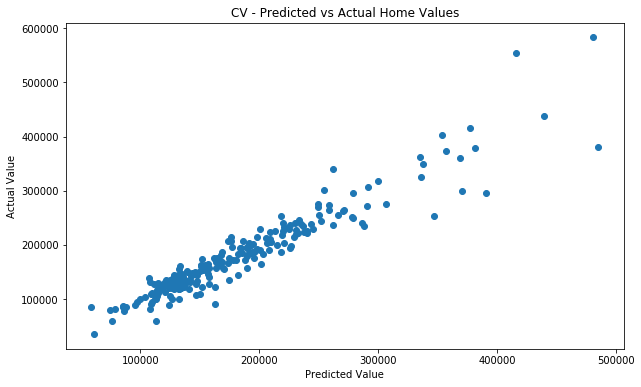

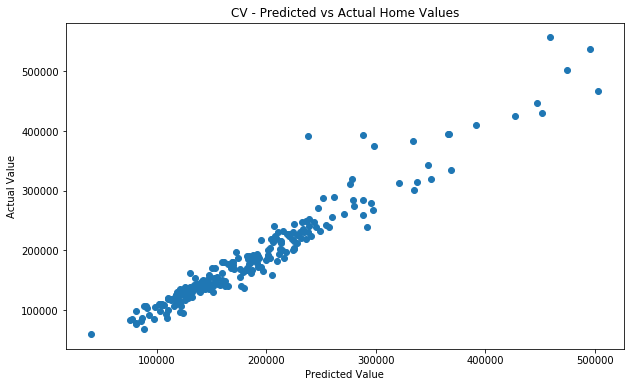

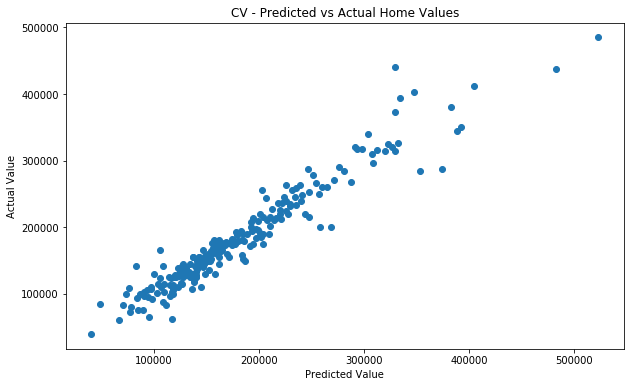

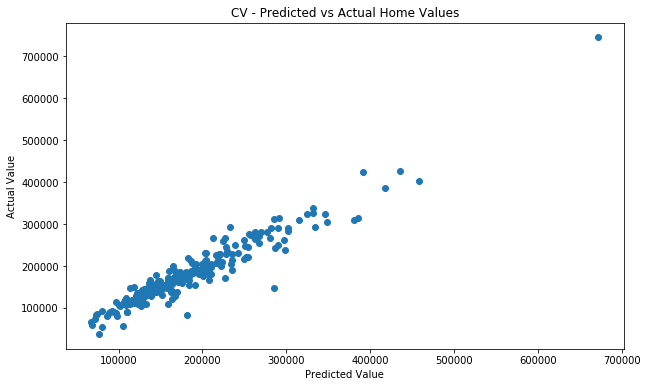

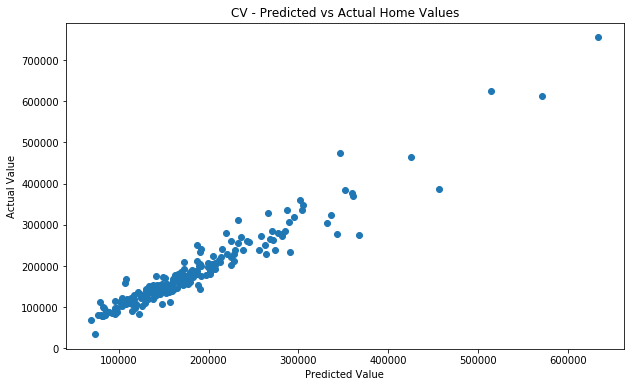

In [31]:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [ ]:
### Adaboost